# Импортируем необходимые библиотеки

In [1]:
import pydicom
import os
from collections import defaultdict
from pathlib import Path
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from pydicom import Dataset
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut, apply_windowing

# Задаем глобальные переменные

In [2]:
PATH_TO_DATA = Path('./data')
RANDOM_FILE = PATH_TO_DATA / "IOP.25"

# Работа с DICOM

In [3]:
ds = pydicom.dcmread(RANDOM_FILE)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.379.35628835037280.15730.1584619613990.31
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.379
(0002, 0013) Implementation Version Name         SH: 'aia 6.0 (8.3)'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20200311'
(0008, 0013) Instance Creation Time              TM: '094957'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance 

In [4]:
## Работа с тегами
print("Имя пациента:", ds.PatientName) # читаем тег

ds.PatientName = "Дамблдор"

print("Имя пациента:", ds[0x10,0x10].value) # читаем тег, способ 2

del ds.PatientName

assert "PatientName" not in ds

print("Данные тега PixelData: /n", ds.PixelData[:100])

print("Данные тега PixelData в формате numpy: \n", ds.pixel_array)

Имя пациента: patient_001
Имя пациента: Дамблдор
Данные тега PixelData: /n b'0\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf80\xf8'
Данные тега PixelData в формате numpy: 
 [[-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 ...
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]]


In [5]:
# прочитаем все файлы
files = []
for file in os.listdir(PATH_TO_DATA):
    try:
        files.append(pydicom.dcmread(PATH_TO_DATA / file))
    except:
        pass

In [6]:
series = defaultdict(list) # Разделим полученные файлы по сериям
for file in files:
    series[file.SeriesInstanceUID].append(file)
for k,i in series.items():
    print(f"series uid {k} with {len(i)} instances")

series uid 1.2.840.113619.2.379.35628835037280.15730.1584619614728.466 with 116 instances
series uid 1.2.840.113619.2.379.35628835037280.15730.1584619614906.583 with 454 instances
series uid 1.2.840.113619.2.379.35628835037280.15730.1584619613942.5 with 450 instances


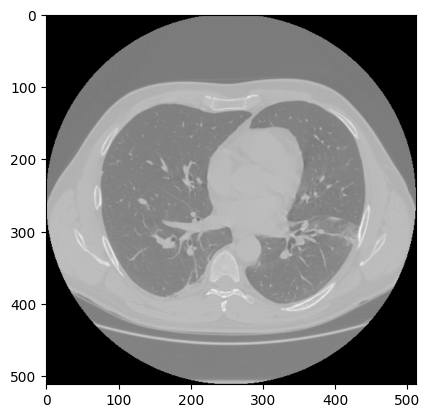

In [7]:
# Будем использовать самую длинную серию
biggest_series = sorted(series.items(), key=lambda x:len(x[1]), reverse=True)[0][1]
plt.imshow(biggest_series[0].pixel_array, cmap="gray")

In [8]:
# почитать про windowing можно тут https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained
def dicom_to_raster(dataset: Dataset) -> np.ndarray:
    img = apply_voi_lut(apply_modality_lut(dataset.pixel_array, dataset), dataset)
    image = img.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return (image * 255).astype("uint8")

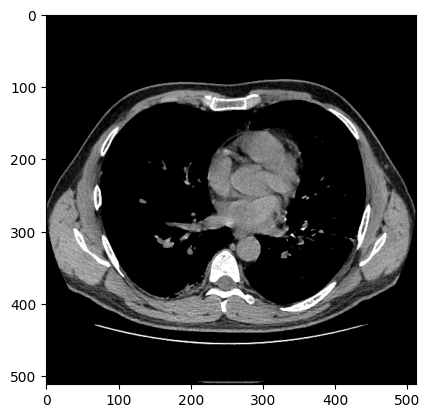

In [9]:
plt.imshow(dicom_to_raster(biggest_series[0]), vmin=0, cmap="gray")

In [10]:
# переведем всю серию в пнг и соберем в единый массив
biggest_series = sorted(biggest_series, key=lambda x: x.SliceLocation)
series_arr = [dicom_to_raster(instance) for instance in biggest_series]
series_arr = np.array(series_arr)
series_arr.shape

(454, 512, 512)

In [11]:
# выберем каждое 10 изображение
series_arr = series_arr[1::10]
series_arr.shape

(46, 512, 512)

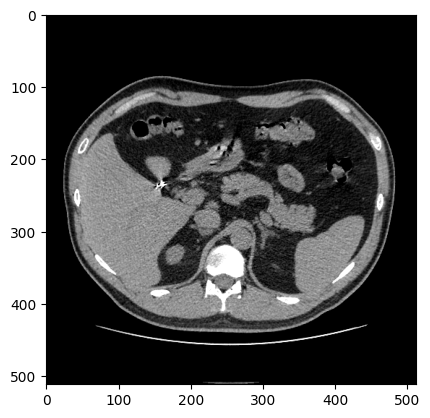

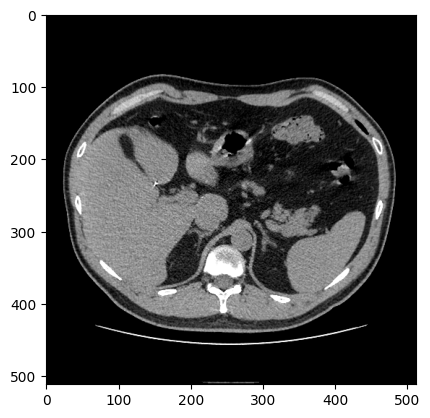

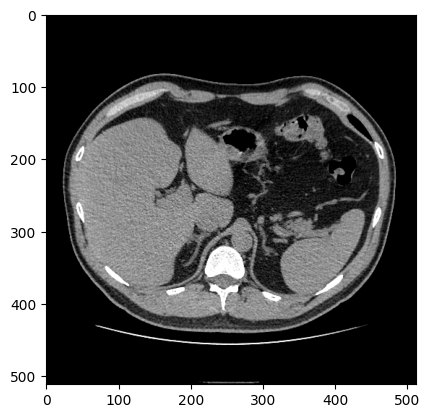

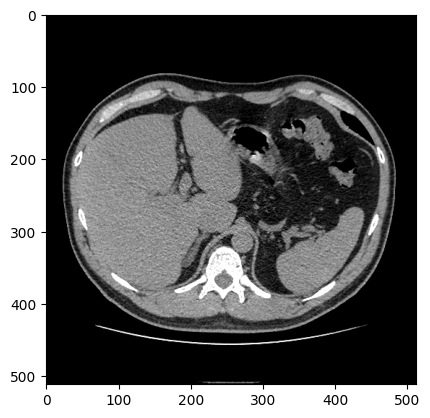

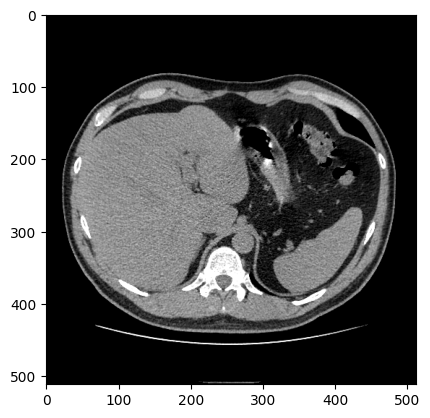

In [12]:
# сохраним в подготовленный файл
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.save(outfile, series_arr)
outfile.seek(0)
read_file = np.load(outfile)
for f in read_file[:5]:
    plt.imshow(f, vmin=0, cmap="gray")
    plt.show()

## Cохраним полученные пнг в формате Dicom

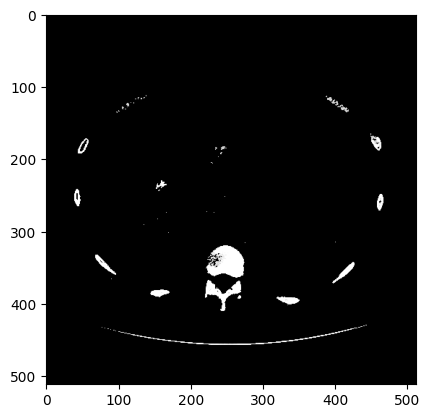

In [13]:
# для демонстрации переведем трешхолдинг и переведем ихображение в 3х канальное
def threshold(img: np.ndarray) -> np.ndarray:
    new_img = img.copy()
    new_img[img<200] = 0
    return cv.cvtColor(new_img, cv.COLOR_GRAY2RGB)

plt.imshow(threshold(series_arr[0]))

In [14]:
# применим функцию для всех элементов
thresholded_series = np.array(list(map(threshold, series_arr)))
thresholded_series.shape

(46, 512, 512, 3)

In [15]:
from pydicom.uid import generate_uid

def create_png_dicom(img: np.array, base_dicom: Dataset) -> Dataset:
    ds = create_basic_dataset(base_dicom)
    ds.PhotometricInterpretation = "RGB"
    ds.Rows = 512
    ds.Columns = 512
    ds.SamplesPerPixel = 3
    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0
    ds.PixelData = img.astype(np.uint8).tobytes()
    ds.is_implicit_VR = True
    ds.is_little_endian = True
    ds.SpecificCharacterSet = "ISO_IR 192"
    
    return ds


def create_basic_dataset(base_dicom: Dataset, add: str = '.123') -> Dataset:
    ds = base_dicom.copy()
    ds.SOPInstanceUID = generate_uid()
    ds.SeriesInstanceUID = base_dicom.SeriesInstanceUID + add
    ds.Modality = "SC"
    ds.walk(delete_tag_group)
    return ds

def delete_tag_group(dataset, data_element):
    if hex(data_element.tag.group) == hex(0x0043) or  hex(data_element.tag.group) == hex(0x0028):
        del dataset[data_element.tag]

In [16]:
for i, (instance, base_dicom) in enumerate(zip(thresholded_series,biggest_series)):
    ds = create_png_dicom(instance, base_dicom)
    ds.save_as(f"./new_data/{i}.dcm", write_like_original=False)